## Strava GPX Analysis
### Manny Lazalde
### August 25, 2024

I want to perform analysis on my Bayshore Marathon 2024 Strava GPX Data. 

Inspired by https://www.youtube.com/watch?v=F6GZdVemCxw&list=PLQ5j-FTc2VhDj93jQas0a8AvNfSMEiDxz

#### Imports

In [121]:
#checking python version
import sys
print(sys.version)

#web url libraries
import requests
import urllib3
import json
from urllib.request import urlopen
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#for getting info from lat/long
#from geopy.geocoders import Nominatim

import pandas as pd
#Datetime will allow Python to recognize dates as dates, not strings.
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt

import folium
import xyzservices.providers as xyz
import io
from PIL import Image, ImageFont, ImageDraw

from typing import Dict, Union
from datetime import datetime


3.10.15 | packaged by conda-forge | (main, Sep 20 2024, 16:26:40) [MSC v.1941 64 bit (AMD64)]


#### GPX Extraction

In [161]:
#from: https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

def get_gpx_point_data(point: gpxpy.gpx.GPXTrackPoint) -> Dict[str, Union[float, datetime, int]]:
        """Return a tuple containing some key data about `point`."""
        
        data = {
            'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation,
            'time': point.time
        }
    
        # The XML namespaces used by the GPX file for extensions, used when parsing the extensions
        NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}

        # Parse extensions for heart rate and cadence data, if available
        elem = point.extensions[0]  # Assuming we know there is only one extension
        try:
            data['heart_rate'] = int(elem.find('garmin_tpe:hr', NAMESPACES).text)
        except AttributeError:
            # "text" attribute not found, so data not available
            pass
            
        try:
            data['cadence'] = int(elem.find('garmin_tpe:cad', NAMESPACES).text)
        except AttributeError:
            pass

        return data

def get_dataframe_from_gpx(fname: str) -> pd.DataFrame:
    """Takes the path to a GPX file (as a string) and returns a Pandas
    DataFrame.
    """
    with open(fname) as f:
        gpx = gpxpy.parse(f)
    segment = gpx.tracks[0].segments[0]  # Assuming we know that there is only one track and one segment
    data = [get_gpx_point_data(point) for point in segment.points]
    route_df = pd.DataFrame(data, columns=['latitude', 'longitude', 'elevation', 'time', 'heart_rate', 'cadence'])

    info_df = pd.DataFrame([{'name': gpx.tracks[0].name,
                            'distance': (gpx.tracks[0].segments[0].length_3d())/ 1609.34, # meters to miles
                            'time': (route_df['time'].iloc[-1] - route_df['time'].iloc[0]), 
                            }])
    info_df['pace'] = str(round(divmod(((info_df['time'].iloc[0].seconds/60) / info_df['distance'].iloc[0]) * 60, 60)[0])) + ':' + \
                        str(round(divmod(((info_df['time'].iloc[0].seconds/60) / info_df['distance'].iloc[0]) * 60, 60)[1]))

    route_df['date'] = route_df['time'].dt.date
    route_df['time'] = route_df['time'].dt.tz_convert('US/Eastern').dt.strftime("%H:%M:%S")
    route_df = route_df[['date','time','latitude','longitude','elevation','heart_rate','cadence']]

    
    return route_df, info_df



In [162]:
route_df, info_df = get_dataframe_from_gpx('Bayshore_Marathon.gpx')

#save to .csv with latitude, longitude, and altitude
#route_df.to_csv('Bayshore_Marathon.csv', index=False)


In [124]:
route_df

date      time   latitude  longitude  elevation  heart_rate  \
0     2024-10-06  07:13:58  42.533758 -83.513601      293.8         117   
1     2024-10-06  07:13:59  42.533758 -83.513601      293.8         117   
2     2024-10-06  07:14:00  42.533758 -83.513601      293.8         117   
3     2024-10-06  07:14:01  42.533758 -83.513601      293.8         117   
4     2024-10-06  07:14:02  42.533758 -83.513601      293.8         117   
...          ...       ...        ...        ...        ...         ...   
4333  2024-10-06  08:26:32  42.533719 -83.514638      288.8         140   
4334  2024-10-06  08:26:33  42.533719 -83.514638      288.8         140   
4335  2024-10-06  08:26:34  42.533719 -83.514638      288.8         140   
4336  2024-10-06  08:26:35  42.533673 -83.514778      289.0         140   
4337  2024-10-06  08:26:36  42.533673 -83.514778      289.0         140   

      cadence  
0          98  
1          98  
2          98  
3          98  
4          94  
...       ...  
4333       82  
4334       82  
4335       82  
4336       82  
4337       82  

[4338 rows x 7 columns]

#### Folium Map

In [125]:
lat =  route_df['latitude'][len(route_df)/2]
long = route_df['longitude'][len(route_df)/2]

route_map = folium.Map(
    location=[lat,	long],
    zoom_start=11,
    # attr = (
    # '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    # 'contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>'
    # ),
    # tiles = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"

    attr = (
        '&copy; <a href="https://stadiamaps.com/" target="_blank">Stadia Maps</a>'
        '&copy; <a href="https://stamen.com/" target="_blank">Stamen Design</a>' 
        '&copy; <a href="https://openmaptiles.org/" target="_blank">OpenMapTiles</a>' 
        '&copy; <a href="https://www.openstreetmap.org/copyright" target="_blank">OpenStreetMap</a>'
        ),
    tiles = "https://tiles.stadiamaps.com/tiles/stamen_watercolor/{z}/{x}/{y}.jpg?api_key=79d21fa8-7dc9-4a9e-887b-4ad3d9df072e"
)


for _, row in route_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
    ).add_to(route_map)

display(route_map)

In [126]:
route_map = folium.Map(
    location=[lat,	long],
    zoom_start=11,
    )

#Add the Stadia Maps Stamen Toner provider details via xyzservices
tile_provider = xyz.Stadia.AlidadeSmooth

#Update the URL to include the API key placeholder
tile_provider["url"] = tile_provider["url"] + "?api_key={api_key}"

#Create the folium TileLayer, specifying the API key
folium.TileLayer(
    tiles=tile_provider.build_url(api_key='79d21fa8-7dc9-4a9e-887b-4ad3d9df072e'),
    attr=tile_provider.attribution,
    name=tile_provider.name,
    max_zoom=tile_provider.max_zoom,
    detect_retina=True
).add_to(route_map)

folium.LayerControl().add_to(route_map)
#route_map
tile_provider


{'url': 'https://tiles.stadiamaps.com/tiles/alidade_smooth/{z}/{x}/{y}{r}.png?api_key={api_key}',
 'max_zoom': 20,
 'html_attribution': '&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmaptiles.org/">OpenMapTiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors',
 'attribution': '(C) Stadia Maps, (C) OpenMapTiles (C) OpenStreetMap contributors',
 'name': 'Stadia.AlidadeSmooth'}

In [127]:
route_map = folium.Map(
    location=[lat,long],
    zoom_start=11,
    )

#Add the Stadia Maps Stamen Toner provider details via xyzservices
tile_provider = xyz.Stadia.AlidadeSmooth

#Update the URL to include the API key placeholder
tile_provider["url"] = tile_provider["url"] + "?api_key={api_key}"

#Create the folium TileLayer, specifying the API key
folium.TileLayer(
    tiles=tile_provider.build_url(api_key='79d21fa8-7dc9-4a9e-887b-4ad3d9df072e'),
    attr=tile_provider.attribution,
    name=tile_provider.name,
    max_zoom=tile_provider.max_zoom,
    detect_retina=True
).add_to(route_map)

folium.LayerControl().add_to(route_map)

for _, row in route_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,
    ).add_to(route_map)

route_map


In [128]:
img_data = route_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save("easy_run.png")

#### Manipulating Map Image

In [129]:
# Specify the width of the margin to top,right, bottom,left, and the background color (R, G, B) (maximum value is 255) to color.
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [130]:
route_df

date      time   latitude  longitude  elevation  heart_rate  \
0     2024-10-06  07:13:58  42.533758 -83.513601      293.8         117   
1     2024-10-06  07:13:59  42.533758 -83.513601      293.8         117   
2     2024-10-06  07:14:00  42.533758 -83.513601      293.8         117   
3     2024-10-06  07:14:01  42.533758 -83.513601      293.8         117   
4     2024-10-06  07:14:02  42.533758 -83.513601      293.8         117   
...          ...       ...        ...        ...        ...         ...   
4333  2024-10-06  08:26:32  42.533719 -83.514638      288.8         140   
4334  2024-10-06  08:26:33  42.533719 -83.514638      288.8         140   
4335  2024-10-06  08:26:34  42.533719 -83.514638      288.8         140   
4336  2024-10-06  08:26:35  42.533673 -83.514778      289.0         140   
4337  2024-10-06  08:26:36  42.533673 -83.514778      289.0         140   

      cadence  
0          98  
1          98  
2          98  
3          98  
4          94  
...       ...  
4333       82  
4334       82  
4335       82  
4336       82  
4337       82  

[4338 rows x 7 columns]

In [163]:
info_df

name   distance            time  pace
0  Bayshore Marathon  26.435855 0 days 02:49:05  6:24

6:24


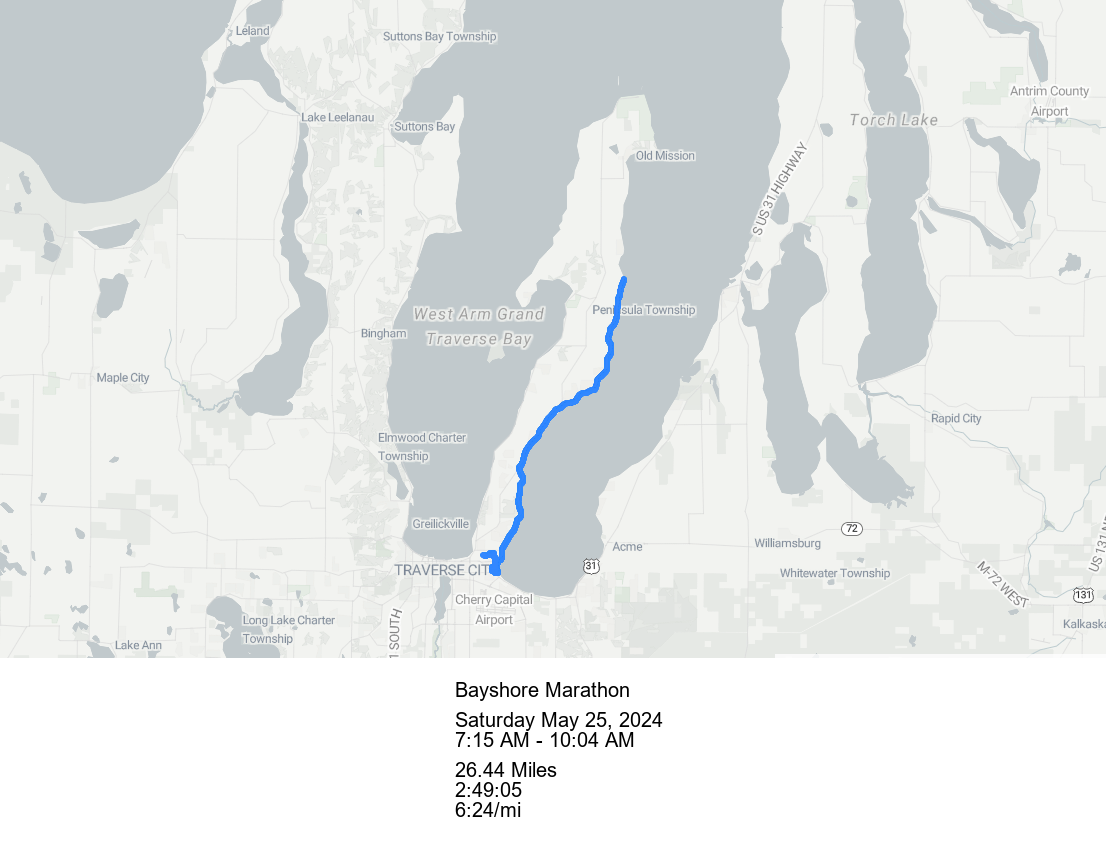

In [169]:
# open image and get attributes
im = Image.open('Bayshore_folium.png')
width,height = im.size


# Crop the image
im_new = im.crop((60,100, width-200, height-10))
im_new = add_margin(im_new, 0,0,200,0, (255,255,255))


# grab important text
spelled_out_date = route_df['date'][0].strftime('%A %B %d, %Y')
spelled_out_start_time = pd.to_datetime(route_df['time'], format="%H:%M:%S").dt.strftime('%#H:%M %p').iloc[0]
spelled_out_end_time = pd.to_datetime(route_df['time'], format="%H:%M:%S").dt.strftime('%#H:%M %p').iloc[-1]
spelled_out_start_end = spelled_out_start_time +' - ' + spelled_out_end_time
spelled_out_elapsed_time = time.strftime('%#H:%M:%S', time.gmtime(info_df['time'][0].seconds))
distance = str(round(info_df['distance'].iloc[0],2)) + " Miles"
name = info_df['name'].iloc[0]
pace = info_df['pace'].iloc[0] + '/mi'


#add text to image
draw = ImageDraw.Draw(im_new)
my_font = ImageFont.truetype('arial.ttf', 20) # font = ImageFont.truetype(<font-file>, <font-size>)
#draw.text((width/3, height - 20),"Sample Text",(0,0,0),font = my_font) # draw.text((x, y),"Sample Text",(r,g,b))
draw.text((width/3, height - 90),name,(0,0,0),font = my_font)
draw.text((width/3, height - 60),spelled_out_date,(0,0,0),font = my_font)
draw.text((width/3, height - 40),spelled_out_start_end,(0,0,0),font = my_font)
draw.text((width/3, height - 10),distance,(0,0,0),font = my_font)
draw.text((width/3, height + 10),spelled_out_elapsed_time,(0,0,0),font = my_font)
draw.text((width/3, height + 30),pace,(0,0,0),font = my_font)




#display image
im_new

#### Code for Grabbing Strava Data

In [113]:
#Taken from https://github.com/fpolignano/Code_From_Tutorials/blob/master/Strava_Api/strava_api.py
#Code to grab current Strava data

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "91559",
    'client_secret': '0b4ba39eb19596b212db839859d53038ee0ef8cb',
    'refresh_token': 'fa0ed46c3baec8feeac22cf4c3819a3758439b4a',
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}

## Updating this portion to grab all of the runs from Strava in total, instead of just the last 200

#param = {'per_page': 200, 'page': 1}
#my_dataset = requests.get(activites_url, headers=header, params=param).json()
#print(my_dataset[0]["name"])
#print(my_dataset[0]["map"]["summary_polyline"])

param = {'per_page': 200, 'page': 1}
#store strava data in list, cause too complicated to merge in while loop
df_list = []

while True:
    
    #grab the data from strava through an http request
    r = requests.get(activites_url, headers=header, params=param).json()
    
    # if no results then exit loop
    if (not r):
        break
    
    #store dataframes in list
    df_list.append(pd.json_normalize(r))
    
    #keep iterating till all data is collected
    param['page'] = param['page'] + 1

print("Success! Got it all without error!")

Requesting Token...

Access Token = 699633ba4463304d2ca670f5a62e494aef1d3e91

Success! Got it all without error!


In [120]:
df_list[0].iloc[0]['distance']

np.float64(14519.8)

#### Code for performing data analysis on Strava Data

In [3]:
# First move is to take list of all dataframes and merge to single dataframe. Do so below
activities = df_list[0]

for i in range(len(df_list)):
    if i == 0:
        continue
    activities = pd.concat([activities,df_list[i]])

#export to csv for visualization
activities.to_csv("Activies.csv")

#lets drop the useless columns
activities = activities[['resource_state', 'name', 'distance','elapsed_time',
       'total_elevation_gain', 'type', 'workout_type', 'id',
       'start_date_local', 'timezone',
        'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'elev_high', 'elev_low', 'athlete.id']]


#Perform data manipulation
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])
activities['start_time'] = activities['start_date_local'].dt.time
activities['start_date_local'] = activities['start_date_local'].dt.date
activities['distance_miles'] = round(activities['distance'] / 1609.34,2)
activities['time_minutes'] = round(activities['elapsed_time'] / 60)

#grab city from start_lat/long - Have to be careful with this if desired
# https://operations.osmfoundation.org/policies/nominatim/
#geolocator = Nominatim(user_agent="test")
#location = geolocator.reverse("42.3513587, -83.0653791")

#export to excel for visualization
activities.to_excel("Activies.xlsx")

#activities